## Libraries

In [171]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

In [173]:
DATASET_PATH = "Dataset/Churn_Modelling.csv"

In [174]:
def loadData(path):
    if(os.path.exists(path)):
        return pd.read_csv(path)

## Training data preparation

In [175]:
Training_Data = loadData(DATASET_PATH)

In [176]:
Irrelavant_Columns = ["RowNumber","CustomerId","Surname"]

In [177]:
Training_Data = Training_Data.drop(Irrelavant_Columns, axis=1)

In [178]:
def getColumns(dataframe:pd.DataFrame):
    columns = list(dataframe.columns)
    categorical_columns = set()
    for col in columns:
        if dataframe[col].dtype == np.dtype('object'):
            categorical_columns.add(col)
    return (list(set(columns).difference(categorical_columns)) , list(categorical_columns))

In [179]:
def metrics(y_test , y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Precision
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision}")

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall}")

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC Score: {roc_auc}")

    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    return (precision, recall, f1)

In [180]:
num,  cat = getColumns(Training_Data.drop(["Exited"], axis=1))

def pipeline():
    preprocessing_pipeline = ColumnTransformer([
        ('scaler' , StandardScaler() , num),
        ('onehot' , OneHotEncoder(), cat),
    ])
    return preprocessing_pipeline

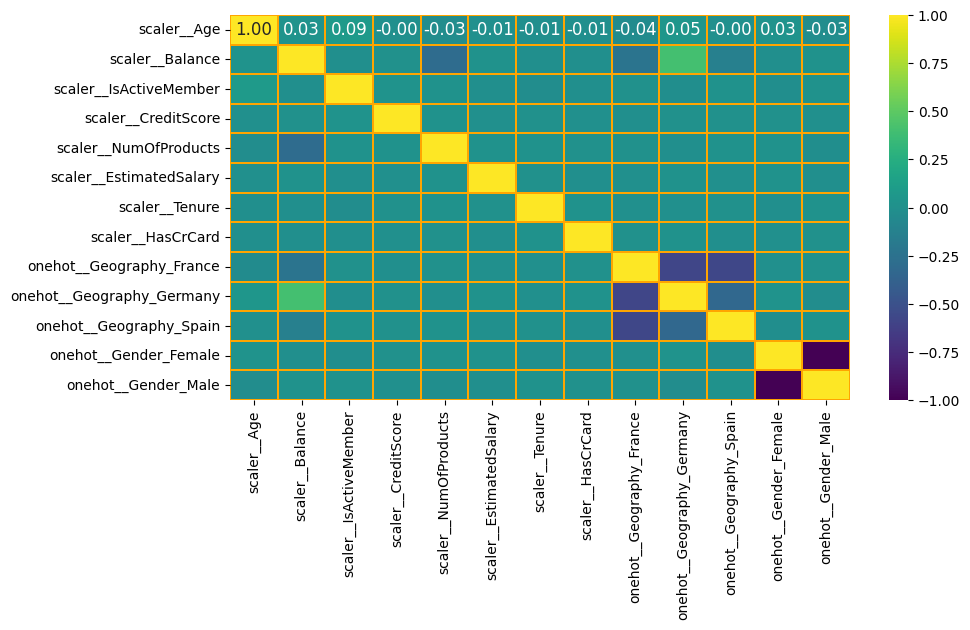

In [181]:
infer_pipeline = pipeline()
infer_data = infer_pipeline.fit_transform(Training_Data)
infer_data = pd.DataFrame(infer_data , columns=infer_pipeline.get_feature_names_out())
plt.figure(figsize = [10,5])
fig = sns.heatmap(infer_data.corr(), cmap='viridis', annot=True, linecolor='orange',linewidths=0.01, annot_kws={"fontsize":12}, fmt="0.2f")

In [182]:
X_train, X_val, y_train, y_val = train_test_split(Training_Data.drop('Exited', axis=1), Training_Data['Exited'], test_size=0.2, random_state=42)

In [183]:
preprocessing_pipeline = pipeline()
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train, y_train)

In [184]:
preprocessing_pipeline.get_feature_names_out()

array(['scaler__Age', 'scaler__Balance', 'scaler__IsActiveMember',
       'scaler__CreditScore', 'scaler__NumOfProducts',
       'scaler__EstimatedSalary', 'scaler__Tenure', 'scaler__HasCrCard',
       'onehot__Geography_France', 'onehot__Geography_Germany',
       'onehot__Geography_Spain', 'onehot__Gender_Female',
       'onehot__Gender_Male'], dtype=object)

In [185]:
X_test_preprocessed = preprocessing_pipeline.transform(X_val)

## Models

In [186]:
validation_results = dict()

### Random forest

In [187]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_preprocessed, y_train)

y_pred_rf = rf_classifier.predict(X_test_preprocessed)
precision , recall , f1 = metrics(y_val , y_pred_rf)
validation_results["RandomForest"] = [precision, recall, f1]

Accuracy: 0.8645
Precision: 0.7606837606837606
Recall: 0.4529262086513995
F1 Score: 0.5677830940988836
Confusion Matrix:
[[1551   56]
 [ 215  178]]
ROC-AUC Score: 0.7090393333238328
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.76      0.45      0.57       393

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.86      0.86      0.85      2000



### XGBoost

In [188]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier( use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train_preprocessed, y_train)

y_pred_xgb = xgb_classifier.predict(X_test_preprocessed)
precision , recall , f1  = metrics(y_val , y_pred_xgb)
validation_results["XGBoost"] = [precision, recall, f1]

Accuracy: 0.8625
Precision: 0.7062937062937062
Recall: 0.5139949109414759
F1 Score: 0.5949926362297496
Confusion Matrix:
[[1523   84]
 [ 191  202]]
ROC-AUC Score: 0.7308617989679377
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1607
           1       0.71      0.51      0.59       393

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.76      2000
weighted avg       0.85      0.86      0.85      2000



### Decision Tree

In [189]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_preprocessed, y_train)

y_pred_dt = dt_classifier.predict(X_test_preprocessed)
precision , recall , f1  = metrics(y_val , y_pred_dt)
validation_results["DecisionTree"] = [precision, recall, f1]

Accuracy: 0.777
Precision: 0.4396355353075171
Recall: 0.4910941475826972
F1 Score: 0.4639423076923077
Confusion Matrix:
[[1361  246]
 [ 200  193]]
ROC-AUC Score: 0.6690069368902908
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1607
           1       0.44      0.49      0.46       393

    accuracy                           0.78      2000
   macro avg       0.66      0.67      0.66      2000
weighted avg       0.79      0.78      0.78      2000



## Results

In [190]:
val_results = pd.DataFrame.from_dict(validation_results , orient='index')

In [191]:
columns = ['Precision', 'Recall', 'F1']
val_results.index = list(validation_results.keys())
val_results.columns = columns

In [192]:
val_results

,Precision,Recall,F1
RandomForest,0.760684,0.452926,0.567783
XGBoost,0.706294,0.513995,0.594993
DecisionTree,0.439636,0.491094,0.463942
